<a href="https://colab.research.google.com/github/cansir1/Emotion/blob/main/emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"debopambanik","key":"9f0d25fd975bafd087edc8ac03758d71"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp


Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
emotions-dataset-for-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip emotions-dataset-for-nlp.zip

Archive:  emotions-dataset-for-nlp.zip
replace test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


In [8]:
train_df = pd.read_csv('train.txt', sep=';', names=['text', 'emotion'])
val_df = pd.read_csv('val.txt', sep=';', names=['text', 'emotion'])
test_df = pd.read_csv('test.txt', sep=';', names=['text', 'emotion'])

In [9]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
test_df.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [11]:
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [12]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize # Keep import for now, but not used in clean_text below
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters # Keep import for now, but not used in clean_text below

# Ensure all NLTK data is downloaded
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)


# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()




def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = re.findall(r'\b\w+\b', text) # Use regex for tokenization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

val_df['clean_text'] = val_df['text'].apply(clean_text)

In [14]:
train_df.head()

,text,emotion,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can tune max_features

# Fit on train and transform all sets
X_train = tfidf.fit_transform(train_df['clean_text'])
X_val = tfidf.transform(val_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])


In [1]:
!pip install --upgrade numpy gensim scipy
import gensim.downloader as api

# Download the pretrained Word2Vec model (300D Google News)
word2vec = api.load('word2vec-google-news-300')  # ~1.5GB, might take time

  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [16]:
import numpy as np

def get_w2v_vector(text):
    words = text.split()
    word_vecs = [word2vec[word] for word in words if word in word2vec]
    if len(word_vecs) == 0:
        return np.zeros(300)  # return zero vector if no known words
    return np.mean(word_vecs, axis=0)

# Apply to all datasets
X_train_w2v = np.vstack(train_df['clean_text'].apply(get_w2v_vector))
X_val_w2v = np.vstack(val_df['clean_text'].apply(get_w2v_vector))
X_test_w2v = np.vstack(test_df['clean_text'].apply(get_w2v_vector))


In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode labels (emotion column)
le = LabelEncoder()
y_train = le.fit_transform(train_df['emotion'])
y_val = le.transform(val_df['emotion'])
y_test = le.transform(test_df['emotion'])  # use transform, not fit_transform


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = clf.predict(X_val)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 0.876

Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.83      0.87       275
        fear       0.86      0.77      0.81       212
         joy       0.87      0.94      0.90       704
        love       0.87      0.74      0.80       178
     sadness       0.88      0.94      0.91       550
    surprise       0.88      0.60      0.72        81

    accuracy                           0.88      2000
   macro avg       0.88      0.80      0.83      2000
weighted avg       0.88      0.88      0.87      2000



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_w2v, y_train)

# Predict on validation set
y_val_pred = clf.predict(X_val_w2v)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names=le.classes_))


Validation Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

       anger       0.75      0.57      0.65       275
        fear       0.68      0.62      0.65       212
         joy       0.76      0.85      0.80       704
        love       0.70      0.40      0.51       178
     sadness       0.68      0.81      0.74       550
    surprise       0.66      0.41      0.50        81

    accuracy                           0.72      2000
   macro avg       0.71      0.61      0.64      2000
weighted avg       0.72      0.72      0.71      2000



In [20]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
svm_model = LinearSVC()

# Train model
svm_model.fit(X_train, y_train)

# Predict on val data
svm_preds = svm_model.predict(X_val)

# Evaluate performance
print("✅ SVM Accuracy:", accuracy_score(y_val, svm_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, svm_preds))


✅ SVM Accuracy: 0.901

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       275
           1       0.87      0.82      0.84       212
           2       0.92      0.93      0.93       704
           3       0.82      0.81      0.82       178
           4       0.91      0.94      0.93       550
           5       0.83      0.79      0.81        81

    accuracy                           0.90      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



In [21]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
svm_model = LinearSVC()

# Train model
svm_model.fit(X_train_w2v, y_train)

# Predict on val data
svm_preds = svm_model.predict(X_val_w2v)

# Evaluate performance
print("✅ SVM Accuracy:", accuracy_score(y_val, svm_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, svm_preds))


✅ SVM Accuracy: 0.725

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.59      0.66       275
           1       0.66      0.61      0.63       212
           2       0.76      0.85      0.80       704
           3       0.68      0.45      0.54       178
           4       0.70      0.81      0.75       550
           5       0.71      0.43      0.54        81

    accuracy                           0.72      2000
   macro avg       0.71      0.62      0.65      2000
weighted avg       0.72      0.72      0.72      2000



In [22]:
pip install xgboost

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',  # since it's multi-class classification
    num_class=6,                # you have 6 emotion classes (0 to 5)
    eval_metric='mlogloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation data
xgb_preds = xgb_model.predict(X_val)

# Evaluate performance
print("✅ XGBoost Accuracy:", accuracy_score(y_val, xgb_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, xgb_preds))


✅ XGBoost Accuracy: 0.892

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       275
           1       0.83      0.85      0.84       212
           2       0.91      0.91      0.91       704
           3       0.80      0.88      0.84       178
           4       0.93      0.91      0.92       550
           5       0.83      0.78      0.80        81

    accuracy                           0.89      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.89      0.89      0.89      2000



In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model (no need for use_label_encoder anymore)
xgb_model = XGBClassifier(
    objective='multi:softmax',   # For multi-class classification
    num_class=6,                 # Total number of emotion classes
    eval_metric='mlogloss',     # Log loss is standard for classification
    random_state=42
)

# Train on Word2Vec features
xgb_model.fit(X_train_w2v, y_train)

# Predict on validation set
xgb_preds = xgb_model.predict(X_val_w2v)

# Evaluate
print("✅ XGBoost Accuracy (Word2Vec):", accuracy_score(y_val, xgb_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, xgb_preds))


✅ XGBoost Accuracy (Word2Vec): 0.6955

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.54      0.63       275
           1       0.67      0.57      0.62       212
           2       0.71      0.85      0.77       704
           3       0.66      0.32      0.43       178
           4       0.67      0.81      0.74       550
           5       0.80      0.25      0.38        81

    accuracy                           0.70      2000
   macro avg       0.71      0.56      0.59      2000
weighted avg       0.70      0.70      0.68      2000



In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
nb_model = GaussianNB()

# Train model on Word2Vec features
nb_model.fit(X_train_w2v, y_train)

# Predict on validation data
nb_preds = nb_model.predict(X_val_w2v)

# Evaluate performance
print("✅ Naive Bayes Accuracy (Word2Vec):", accuracy_score(y_val, nb_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, nb_preds))


✅ Naive Bayes Accuracy (Word2Vec): 0.54

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.47      0.51       275
           1       0.48      0.50      0.48       212
           2       0.69      0.60      0.64       704
           3       0.30      0.60      0.40       178
           4       0.69      0.49      0.57       550
           5       0.25      0.58      0.35        81

    accuracy                           0.54      2000
   macro avg       0.49      0.54      0.49      2000
weighted avg       0.60      0.54      0.55      2000



In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
nb_model = MultinomialNB()

# Train model on TF-IDF features
nb_model.fit(X_train, y_train)

# Predict on validation data
nb_preds = nb_model.predict(X_val)

# Evaluate performance
print("✅ Naive Bayes Accuracy (TF-IDF):", accuracy_score(y_val, nb_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, nb_preds))


✅ Naive Bayes Accuracy (TF-IDF): 0.7455

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.55      0.70       275
           1       0.90      0.43      0.59       212
           2       0.71      0.97      0.82       704
           3       0.97      0.17      0.30       178
           4       0.71      0.95      0.81       550
           5       1.00      0.11      0.20        81

    accuracy                           0.75      2000
   macro avg       0.88      0.53      0.57      2000
weighted avg       0.80      0.75      0.71      2000



In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define parameter grid
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Regularization strength
}

# Create LinearSVC model
svc = LinearSVC(max_iter=5000)

# Setup GridSearch
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("✅ Best Params:", grid_search.best_params_)
print("🎯 Best CV Accuracy:", grid_search.best_score_)

# Evaluate on validation set
best_svc = grid_search.best_estimator_
svm_preds = best_svc.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report
print("📈 Validation Accuracy:", accuracy_score(y_val, svm_preds))
print("\n📊 Classification Report:\n", classification_report(y_val, svm_preds))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Params: {'C': 1}
🎯 Best CV Accuracy: 0.887875
📈 Validation Accuracy: 0.901

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91       275
           1       0.87      0.82      0.84       212
           2       0.92      0.93      0.93       704
           3       0.82      0.81      0.82       178
           4       0.91      0.94      0.93       550
           5       0.83      0.79      0.81        81

    accuracy                           0.90      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



In [29]:
from scipy.sparse import vstack
import numpy as np

# Combine training and validation data
X_final_train = vstack([X_train, X_val])  # For sparse TF-IDF matrices
y_final_train = np.concatenate([y_train, y_val])  # For label-encoded arrays

# Train the final model with best param from GridSearch (C=1)
from sklearn.svm import LinearSVC
final_model = LinearSVC(C=1, max_iter=5000)
final_model.fit(X_final_train, y_final_train)


LinearSVC(C=1, max_iter=5000)

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
y_pred = final_model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Test Accuracy: 0.8930
📊 Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.89      0.88       275
        fear       0.88      0.84      0.86       224
         joy       0.91      0.93      0.92       695
        love       0.79      0.78      0.78       159
     sadness       0.93      0.93      0.93       581
    surprise       0.69      0.67      0.68        66

    accuracy                           0.89      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


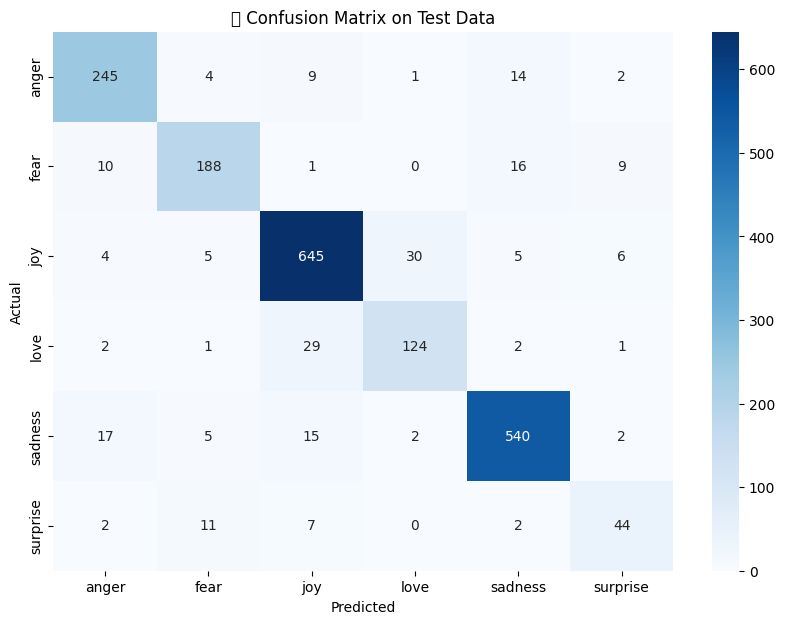

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('🌀 Confusion Matrix on Test Data')
plt.show()
